In [2]:
import pandas as pd 
from sklearn.metrics import pairwise_distances
import numpy as np
from collections import Counter`
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
data = pd.read_csv('1882_annuaire/1882-Tаблица 1.csv', sep=';')
data = data.replace('_', np.nan)
data = data.replace('Objets d\'art', 'Other')
data = data.dropna(subset=['Objets collectionnés'])
data.head(10)

,Département,Ville,Nom,Prénom,Profession,N° rue,Rue,Objets collectionnés,Notes (état de la collection)
0,Ain,Bourg,du Péloux,M.,NaN,NaN,NaN,Céramique,NaN
1,Ain,Bourg,du Péloux,M.,NaN,NaN,NaN,Livres,NaN
2,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Ex-libris,4000 environ
3,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Blasons,NaN
4,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Livres de blasons,NaN
5,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Listels ou blasons employés par les Pompes fun...,2000 environs
6,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Sceaux,NaN
7,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Cachets anciens et modernes,NaN
8,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Boutons de livrées,NaN
9,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,"Plaques de harnais, avec armoiries",NaN


In [101]:
city_fr = pd.read_csv('villes_france.csv')
coords = city_fr.iloc[:,19:21]
coords.columns = ['Lat', 'Long']
coords['city'] = city_fr.iloc[:,5]


top_20 = [i[0] for i in Counter(data['Ville'].values).most_common(11)]

def rename_size(size):
    if size not in top_20:
        return 'Other'
    else:
        return size
    
coords['city_sh'] = coords['city'].apply(rename_size)

In [102]:
coords.to_csv('coords.csv')

## 1. Make distance matrices:

In [106]:
def dist_m_prod(by='Nom'):
    d_dum = pd.get_dummies(data[['Objets collectionnés']])
    d_dum[by] = data[by]
    grp_by = pd.DataFrame(d_dum.groupby(by).agg('max'))
    dist = pairwise_distances(d_dum.groupby(by).agg('max'))

    print(np.mean(dist))
    dist = pd.DataFrame(dist)
    dist.index = d_dum.groupby(by).agg('max').index
    dist.columns = d_dum.groupby(by).agg('max').index
    dist.to_csv('dist_matrix_{}.csv'.format(by))
    return grp_by, dist

In [107]:
dummy, by_city = dist_m_prod('Ville')

3.1664640206409924


In [108]:
dummy_p, by_person = dist_m_prod('Nom')

2.1938424811548844


Plot PCA:

In [109]:
# x = StandardScaler().fit_transform(dummy)

In [132]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dummy_p)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])


In [133]:
principalDf['Name'] = dummy_p.index
principalDf['City'] = data.groupby('Nom').last()['Ville'].values

In [134]:
top_20 = [i[0] for i in Counter(data['Ville'].values).most_common(5)]

def rename_size(size):
    if size not in top_20:
        return 'Other'
    else:
        return size
    
principalDf['City_n']= principalDf['City'].apply(rename_size)

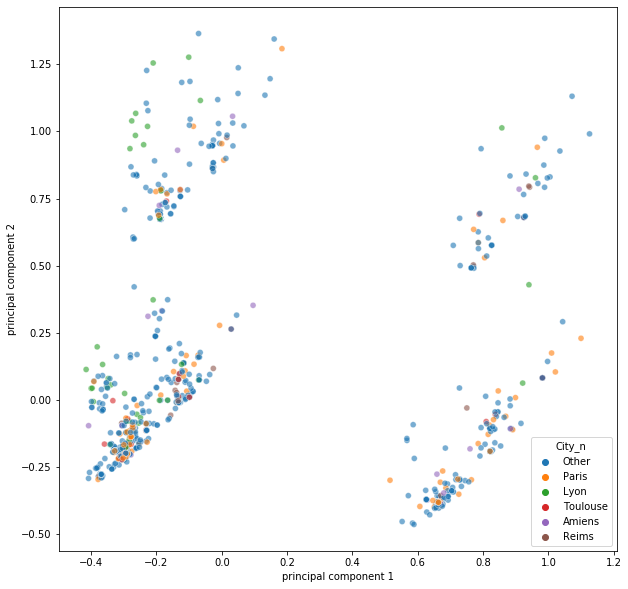

In [135]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=principalDf[principalDf['City'] != 'Other'],
                x='principal component 1', 
                y='principal component 2', hue='City_n', alpha=0.6)

In [62]:
by_person

Nom,Abram,Acy,Agassis,Aigoin,Aigremont,Albin,Alboize,Albrespy,Allain,Allemand,...,Watelet,Wavrin,Weissgerber,Werlé,Werner,Wery-Menesson,Wignier,Willems,Willermoz,du Péloux
Nom,,,,,,,,,,,,,,,,,,,,,
Abram,0.000000,2.828427,2.645751,2.000000,2.645751,2.236068,2.449490,1.732051,2.000000,2.645751,...,3.162278,2.645751,2.236068,3.162278,2.449490,3.162278,2.449490,2.449490,3.162278,2.236068
Acy,2.828427,0.000000,2.236068,2.000000,2.236068,2.236068,2.000000,2.236068,2.000000,2.236068,...,2.828427,2.236068,2.236068,2.828427,2.000000,2.828427,2.000000,2.000000,2.828427,2.236068
Agassis,2.645751,2.236068,0.000000,1.732051,1.414214,2.000000,1.732051,2.000000,1.732051,1.414214,...,1.732051,2.000000,2.000000,2.645751,1.732051,2.645751,1.732051,1.732051,2.645751,2.000000
Aigoin,2.000000,2.000000,1.732051,0.000000,1.732051,1.000000,1.414214,1.000000,0.000000,1.732051,...,2.449490,1.732051,1.000000,2.449490,1.414214,2.449490,1.414214,1.414214,2.449490,1.000000
Aigremont,2.645751,2.236068,1.414214,1.732051,0.000000,2.000000,1.732051,2.000000,1.732051,0.000000,...,1.732051,2.000000,2.000000,2.645751,1.732051,2.645751,1.732051,1.732051,2.236068,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wery-Menesson,3.162278,2.828427,2.645751,2.449490,2.645751,2.645751,2.449490,2.645751,2.449490,2.645751,...,3.162278,2.236068,2.645751,2.828427,2.449490,0.000000,2.449490,2.449490,3.162278,2.645751
Wignier,2.449490,2.000000,1.732051,1.414214,1.732051,1.732051,1.414214,1.732051,1.414214,1.732051,...,2.449490,1.732051,1.732051,2.449490,1.414214,2.449490,0.000000,1.414214,2.449490,1.732051
Willems,2.449490,2.000000,1.732051,1.414214,1.732051,1.732051,1.414214,1.732051,1.414214,1.732051,...,2.449490,1.732051,1.732051,2.449490,1.414214,2.449490,1.414214,0.000000,2.449490,1.732051


In [48]:
principalDf.to_csv('pca.csv')

## 2. Create fake categories:

In [14]:
len(set(data['Objets collectionnés'].values))

1007

In [15]:
Counter(data['Objets collectionnés'].values).most_common(10)

[('Céramique', 307),
 ('Tableaux', 204),
 ('Curiosités', 166),
 ('Mobilier', 132),
 ('Livres', 108),
 ('Numismatique', 107),
 ('Faïences', 94),
 ('Other', 75),
 ('Gravures', 64),
 ('Antiquités', 63)]

In [27]:
top_20 = [i[0] for i in Counter(data['Ville'].values).most_common(11)]

def rename_size(size):
    if size not in top_20:
        return 'Other'
    else:
        return size
    
data['City_subset']= data['Ville'].apply(rename_size)

In [32]:
top_20 =  [i[0] for i in Counter(data['Objets collectionnés'].values).most_common(15)]

def rename_size(size):
    if size not in top_20:
        return 'Other'
    else:
        return size
    
data['Type']= data['Objets collectionnés'].apply(rename_size)

In [33]:
top_20

['Céramique',
 'Tableaux',
 'Curiosités',
 'Mobilier',
 'Livres',
 'Numismatique',
 'Faïences',
 'Other',
 'Gravures',
 'Antiquités',
 'Armes',
 'Tapisseries',
 'Emaux',
 'Ivoires',
 'Mobilier anciens']

In [34]:
data.to_csv('data_mod.csv')

In [30]:
data

,Département,Ville,Nom,Prénom,Profession,N° rue,Rue,Objets collectionnés,Notes (état de la collection),Type,City_subset
0,Ain,Bourg,du Péloux,M.,NaN,NaN,NaN,Céramique,NaN,Céramique,Other
1,Ain,Bourg,du Péloux,M.,NaN,NaN,NaN,Livres,NaN,Livres,Other
2,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Ex-libris,4000 environ,Other,Other
3,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Blasons,NaN,Other,Other
4,Ain,Montréal,Comte de Douglas,NaN,NaN,NaN,Château de Montréal,Livres de blasons,NaN,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...
3447,Yonne,Auxerre,Navarre,M.,Commissaire-priseur,NaN,rue Notre-Dame,Gravures,NaN,Gravures,Other
3448,Yonne,Auxerre,Poncelet,M.,Propriétaire,7,rue de la Vérité,"Objets romains, gallo-romains",NaN,Other,Other
3449,Yonne,Auxerre,Poncelet,M.,Propriétaire,7,rue de la Vérité,Art ancien,NaN,Other,Other
3450,Yonne,Auxerre,Poncelet,M.,Propriétaire,7,rue de la Vérité,Art moderne,NaN,Other,Other
